<a href="https://colab.research.google.com/github/YashKandoi/HuggingFaceModels/blob/main/Blur_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Action Classification Model

1. Fine-tune VideoMAE on a subset of the UCF101 dataset.
2. Use your fine-tuned model for inference.

<!-- Link: https://huggingface.co/docs/transformers/en/tasks/video_classification -->


In [34]:
pip install -q pytorchvideo transformers evaluate

In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [124]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

In [125]:
import tarfile

with tarfile.open(file_path) as t:
     t.extractall(".")

In [126]:
import os

dataset_dir = 'UCF101_subset/'

all_video_file_paths = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.avi') or file.endswith('.mp4'):
            video_path = os.path.join(root, file)
            all_video_file_paths.append(video_path)

print(all_video_file_paths)

['UCF101_subset/train/BandMarching/v_BandMarching_g07_c03.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g04_c04.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g07_c07.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g15_c05.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g02_c06.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g24_c01.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g12_c02.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g14_c05.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g08_c02.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g03_c05.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g09_c07.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g18_c03.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g04_c02.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g02_c02.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g06_c01.avi', 'UCF101_subset/train/BandMarching/v_BandMarching_g03_c

In [127]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


In [128]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preparing the datasets for training

For preprocessing the videos, you will leverage the PyTorchVideo library. Start by importing the dependencies we need.

In [70]:
!pip install pytorchvideo

In [129]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [72]:
# # BDQ method functions
# import cv2
# import math
# import torch
# from torchvision.transforms import Compose, Lambda, Normalize, Resize

#     for i in range(0, height, 5):
#         for j in range(0, width, 5):
#             # Iterate over the diagonal pixels within the 5x5 block
#             for k in range(5):
#                 pixel_pos = (i+k, j+k)  # Adjusted pixel position for the diagonal
#                 noise = np.random.randint(0, 255)
#                 noisy_image[pixel_pos[0], pixel_pos[1]] += noise
#                 # Clip the pixel value to the valid range
#                 noisy_image[pixel_pos[0], pixel_pos[1]] = noisy_image[pixel_pos[0], pixel_pos[1]] % 255

#     noisy_image = noisy_image.astype(np.uint8)
#     return noisy_image

In [198]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

# image upsized to nearest 5*5
# height = math.ceil(height / 5) * 5  # Round up to nearest multiple of 5
# width = math.ceil(width / 5) * 5    # Round up to nearest multiple of 5
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [199]:
dataset_root_path='UCF101_subset/'

In [200]:
import cv2
import torch

def apply_gaussian_blur(frame):
    """Apply pixel-wise blurring using a 5x5 Gaussian kernel to a single frame."""
    # Convert the frame to a numpy array
    frame_np = frame.numpy().astype('uint8')
    # Apply Gaussian blur
    blurred_frame = cv2.GaussianBlur(frame_np, (5, 5), 0)
    # Convert the blurred frame back to a torch tensor
    blurred_frame_tensor = torch.from_numpy(blurred_frame).float()
    return blurred_frame_tensor

In [201]:
from torchvision.transforms.functional import to_tensor

class ApplyGaussianBlurToVideoFrames:
    def __call__(self, video_dict):
        # Get the video tensor
        # print('Hello:')
        # print(video_dict)
        video_tensor = video_dict
        # Initialize a list to store blurred frames
        blurred_frames = []
        # Iterate over the frames and apply the transformation
        for frame_idx in range(video_tensor.size(0)):
            # Get a single frame tensor
            frame = video_tensor[frame_idx]
            # Apply the transformation to the frame
            blurred_frame = apply_gaussian_blur(frame)
            # Append the blurred frame to the list
            blurred_frames.append(blurred_frame)
        # Convert the list of blurred frames to a tensor
        blurred_video_tensor = torch.stack(blurred_frames)
        # Update the video tensor in the video_dict
        video_dict = blurred_video_tensor
        return video_dict

In [202]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean=mean, std=std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                    ApplyGaussianBlurToVideoFrames(),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [203]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean=mean, std=std),
                    Resize(resize_to),
                    ApplyGaussianBlurToVideoFrames(),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [204]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75


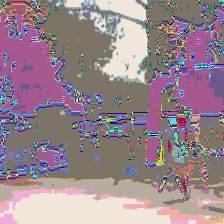

In [223]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [219]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [225]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4
batch_size=4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [226]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [227]:
import torch
torch.cuda.empty_cache()
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [228]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,2.232400,2.236376,0.100000
1,2.137100,2.338655,0.114286


In [ ]:
trainer.push_to_hub()

In [212]:
sample_test_video = next(iter(test_dataset))

In [217]:
from transformers import pipeline

video_cls = pipeline(model="Yash2003/videomae-base-finetuned-ucf101-subset")
video_cls("https://huggingface.co/datasets/sayakpaul/ucf101-subset/resolve/main/v_BasketballDunk_g14_c06.avi")

[{'score': 0.30563756823539734, 'label': 'Archery'},
 {'score': 0.1761535108089447, 'label': 'Basketball'},
 {'score': 0.13253015279769897, 'label': 'BabyCrawling'},
 {'score': 0.08181031793355942, 'label': 'BaseballPitch'},
 {'score': 0.07528200000524521, 'label': 'BenchPress'}]

In [214]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [215]:
logits = run_inference(model, sample_test_video["video"])

In [216]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk
